# Masks Problem Finder

**Machine Specifications**:
- Model: MackBook Pro
- Processor: 2.8 GHz Quad-Core Intel Core i7
- Memory: 16 GB 2133 MHz

**Description of Data Used for Testing**

**Dataset Details**:
- Data Source: EK80 raw data - nice data D20190821-T210646.raw - [link](https://noaa-wcsd-pds.s3.amazonaws.com/index.html#data/raw/Pisces/PC1905/EK80/)
- Raw File Size: 262.2 Megabytes (MB)
- Below is the code to download the test dataset when using a Jupyter notebook.
  ```python
  # Initialize the S3 filesystem using anonymous access
  fs = fsspec.filesystem('s3', anon=True)
  
  bucket = "noaa-wcsd-pds"
  rawdirpath = "data/raw/Pisces/PC1905/EK80"
  
  # List files in the S3 directory
  s3_files = fs.glob(f"{bucket}/{rawdirpath}/*")
  
  # Filter the files based on your criteria (e.g., containing a specific string)
  target_files = [s3path for s3path in s3_files if any([f"D2019{dtstr}" in s3path for dtstr in ['0821-T2106']])]
  
  print(f"There are {len(target_files)} target files available")
  local_folder = oceanstream_ek80_path
  
  # Create the local folder if it doesn't exist
  os.makedirs(local_folder, exist_ok=True)
  
  # Download the filtered files to the local folder
  for s3path in target_files:
      file_name = os.path.basename(s3path)
      local_file_path = os.path.join(local_folder, file_name)
      with fs.open(s3path, 'rb') as s3_file, open(local_file_path, 'wb') as local_file:
          local_file.write(s3_file.read())
  
  print(f"Downloaded {len(target_files)} target raw files to {local_folder}")
  ```

### Setting up project root for module imports in Jupyter Notebook

In [1]:
import os

notebook_path = os.path.abspath("bug_inducing_denoising_masks_finder.ipynb")
notebooks_folder_path = os.path.abspath(os.path.join(notebook_path, os.pardir))
project_root = os.path.abspath(os.path.join(notebook_path, os.pardir, os.pardir))


import sys

sys.path.append(project_root)

**Specifies the path to the test data utilized in this notebook:**

In [2]:
oceanstream_ek80_path = os.path.join(notebooks_folder_path, "test_data", "oceanstream_ek80")

### Imports

In [3]:
import gc
import os
import urllib.request

import echopype.visualize as epviz
import fsspec
import matplotlib.pyplot as plt

from oceanstream.L0_unprocessed_data import raw_handler, ensure_time_continuity
from oceanstream.L2_calibrated_data import (
    sv_computation,
    sv_dataset_extension,
    noise_masks,
    sv_interpolation,
    processed_data_io
)
from oceanstream.L3_regridded_data import (
    applying_masks_handler,
    nasc_computation,
    frequency_differencing_handler,
    shoal_detection_handler
)
from oceanstream.L3_regridded_data.applying_masks_handler import apply_mask_organisms_in_order
from oceanstream.L3_regridded_data.mvbs_computation import compute_mvbs
from oceanstream.utils import add_metadata_to_mask, attach_mask_to_dataset, dict_to_formatted_list

### Performance analysis

1. `%%timeit`:
    - **Description**: Measures the average execution time of the code in the cell. It runs the code multiple times to get a stable estimate, determining the number of loops dynamically based on the code's execution time.
    - **Usage**: Place at the top of a Jupyter cell to time the entire cell.
    - **Example**:
      ```python
      %%timeit
      [x**2 for x in range(1000)]
      ```
    - **Note**: Reports best, average, and worst timings from multiple repetitions.

2. `%%time`:
    - **Description**: Measures the execution time for the code in the cell once, reporting both CPU (processing) time and wall time (real-world time).
    - **Usage**: Place at the top of a Jupyter cell to time the entire cell.
    - **Example**:
      ```python
      %%time
      [x**2 for x in range(1000)]
      ```
    - **Note**: Useful for longer-running code where you want a single measurement rather than an average.

3. `%memit`:
    - **Description**: Measures the peak memory usage of a single line of code. It's part of the `memory_profiler` extension and provides an estimate of the memory consumption.
    - **Usage**: Place before a single line of code in a Jupyter cell.
    - **Example**:
      ```python
      %memit [x**2 for x in range(1000)]
      ```
    - **Note**: To use `%memit`, you need to have the `memory_profiler` extension loaded using `%load_ext memory_profiler`.

In [4]:
# Load the memory_profiler extension to enable memory usage profiling in the notebook
%load_ext memory_profiler

### Analysis Terms:

1. **Memory Usage**:
   - **Peak Memory**: The maximum amount of memory (RAM) used by a process or operation during its execution. It provides an indication of the highest memory demand of the task.
   - **Increment**: The difference in memory usage before and after executing a particular operation. It gives an estimate of how much additional memory was consumed by that operation.

2. **Execution Time**:
   - **CPU times**: The time the Central Processing Unit (CPU) spends on different tasks.
     - **User**: The time the CPU spends running user-defined code. This represents the actual processing time for the given task.
     - **Sys (System)**: The time the CPU spends on system-level operations related to the task, such as memory allocation or input/output operations.
     - **Total**: The combined time of both user and system operations. It provides an overall view of the CPU's engagement with the task.
   - **Wall time**: Also known as "real-world time" or "clock time". It represents the total time taken from the start to the end of an operation, including any time the CPU might spend waiting (e.g., for data retrieval or other processes).

### Downloads the test files

In [5]:
# Initialize the S3 filesystem using anonymous access
fs = fsspec.filesystem('s3', anon=True)

bucket = "noaa-wcsd-pds"
rawdirpath = "data/raw/Pisces/PC1905/EK80"

# List files in the S3 directory
s3_files = fs.glob(f"{bucket}/{rawdirpath}/*")

# Filter the files based on your criteria (e.g., containing a specific string)
target_files = [s3path for s3path in s3_files if any([f"D2019{dtstr}" in s3path for dtstr in ['0821-T2106']])]

print(f"There are {len(target_files)} target files available")


There are 1 target files available


In [6]:
local_folder = oceanstream_ek80_path

# Create the local folder if it doesn't exist
os.makedirs(local_folder, exist_ok=True)

# Download the filtered files to the local folder
for s3path in target_files:
    file_name = os.path.basename(s3path)
    local_file_path = os.path.join(local_folder, file_name)
    with fs.open(s3path, 'rb') as s3_file, open(local_file_path, 'wb') as local_file:
        local_file.write(s3_file.read())

print(f"Downloaded {len(target_files)} target raw files to {local_folder}")

Downloaded 1 target raw files to /Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80


### Files manipulation

**File finder**

In [7]:
%%time

# Displays all `.raw` files from the "oceanstream_ek80" directory
%memit raw_files_path = raw_handler.file_finder(oceanstream_ek80_path, file_type='raw')
display(raw_files_path)

peak memory: 249.85 MiB, increment: 0.04 MiB


['/Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80/D20190821-T210646.raw']

CPU times: user 103 ms, sys: 15 ms, total: 118 ms
Wall time: 658 ms


**File integrity checker**

In [8]:
%%time

# Verifies if the provided echo sounder files are
# readable by echopype and extracts
# essential metadata such as the campaign ID, date of measurement,
# and sonar model.
raw_files_ck = []
for file_path in raw_files_path:
    %memit raw_files_ck.append(raw_handler.file_integrity_checking(file_path))
    
raw_files_ck

peak memory: 7944.45 MiB, increment: 7694.59 MiB
CPU times: user 47.1 s, sys: 36.5 s, total: 1min 23s
Wall time: 1min 29s


[{'file_path': '/Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80/D20190821-T210646.raw',
  'campaign_id': 'D20190821',
  'date': datetime.datetime(2019, 8, 21, 21, 6, 46),
  'sonar_model': 'EK80',
  'file_integrity': True,
  'use_swap': False}]

**Checked raw files reader**

In [9]:
%%time

# Reads multiple raw echo sounder files and returns a list of Datasets.
%memit aug2019_ds = raw_handler.read_raw_files(raw_files_ck)
aug2019_ds[0]

peak memory: 9843.27 MiB, increment: 9589.14 MiB
CPU times: user 34.4 s, sys: 33 s, total: 1min 7s
Wall time: 1min 12s


<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

### Clearing Memory

-  Releasing the memory occupied by the `echodata` object ensures that resources are freed up, especially important in environments like Jupyter notebooks where variables persist in memory until the kernel is restarted.

In [10]:
del aug2019_ds
gc.collect()  # Run the garbage collector to free up memory immediately

44

### NetCDF files obtained from raw files

**Raw file converter to 'nc' or 'zarr'**

In [11]:
%%time

%memit raw_handler.convert_raw_files(raw_files_ck, oceanstream_ek80_path, save_file_type='nc')

peak memory: 8752.09 MiB, increment: 5343.62 MiB
CPU times: user 35.4 s, sys: 36 s, total: 1min 11s
Wall time: 1min 16s


In [12]:
%%time

%memit raw_handler.convert_raw_files(raw_files_ck, oceanstream_ek80_path, save_file_type='zarr')

peak memory: 9658.67 MiB, increment: 9365.91 MiB
CPU times: user 34.8 s, sys: 33.2 s, total: 1min 7s
Wall time: 1min 12s


**File finder**

In [13]:
%%time

# Displays all `.nc` files from the "oceanstream_ek80" directory
%memit nc_files_path = raw_handler.file_finder(oceanstream_ek80_path, file_type='nc')
nc_files_path

peak memory: 310.22 MiB, increment: 0.32 MiB
CPU times: user 135 ms, sys: 392 ms, total: 526 ms
Wall time: 1.67 s


['/Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80/D20190821-T210646.nc']

**File integrity checker**

In [14]:
%%time

nc_files_ck = []
for file_path in nc_files_path:
    %memit nc_files_ck.append(raw_handler.file_integrity_checking(file_path))
    
nc_files_ck

peak memory: 343.00 MiB, increment: 33.11 MiB
CPU times: user 415 ms, sys: 144 ms, total: 559 ms
Wall time: 1.26 s


[{'file_path': '/Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80/D20190821-T210646.nc',
  'campaign_id': 'D20190821',
  'date': datetime.datetime(2019, 8, 21, 21, 6, 46),
  'sonar_model': 'EK80',
  'file_integrity': True}]

**Processed files reader**

In [15]:
%%time

%memit ds = raw_handler.read_processed_files(nc_files_path)

peak memory: 345.01 MiB, increment: 16.75 MiB
CPU times: user 362 ms, sys: 58.8 ms, total: 421 ms
Wall time: 959 ms


In [16]:
ds = ds[0]

### Sv (Volume backscattering strength) computation

In [17]:
%%time

%memit sv = sv_computation.compute_sv(ds, waveform_mode="CW", encode_mode="power")
sv

peak memory: 6732.47 MiB, increment: 6387.43 MiB
CPU times: user 15.2 s, sys: 6.9 s, total: 22.1 s
Wall time: 22.7 s


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 8954,
                                    range_sample: 3890, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-08-21T21:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 3887 3888 3889
  * filenames                      (filenames) int64 0
Data variables: (12/24)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    beamwidth_athwartship          (channel) float64 ...
    impedance_transducer           (channel) int64 75 75 75 75
    impedance_transceiver          (channel) int64 ...
    receiver_sampling_frequency    (channel) float64 ...
    source_filenames               (filenames) <U111 '/Users/simedroniraluca/...
    water_level                    float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2337+g364c06a
    processing_time:              2023-11-16T09:49:07Z
    processing_function:          calibrate.compute_Sv

**Sv - with noise**

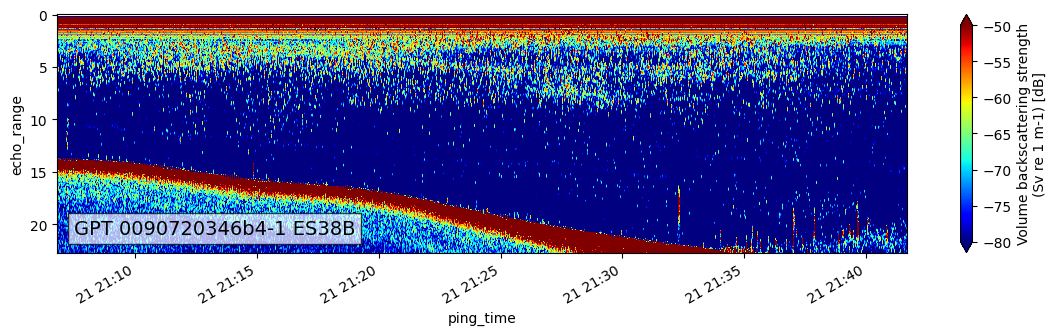

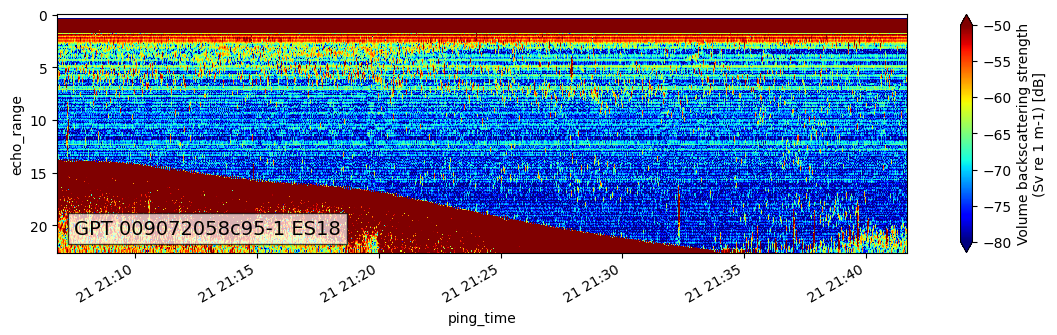

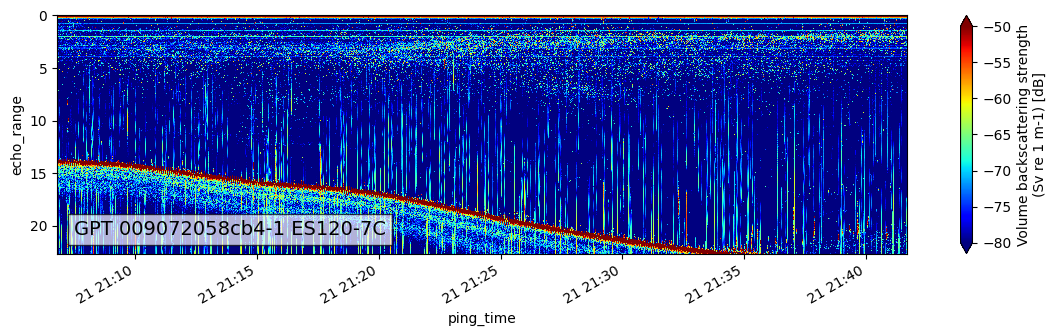

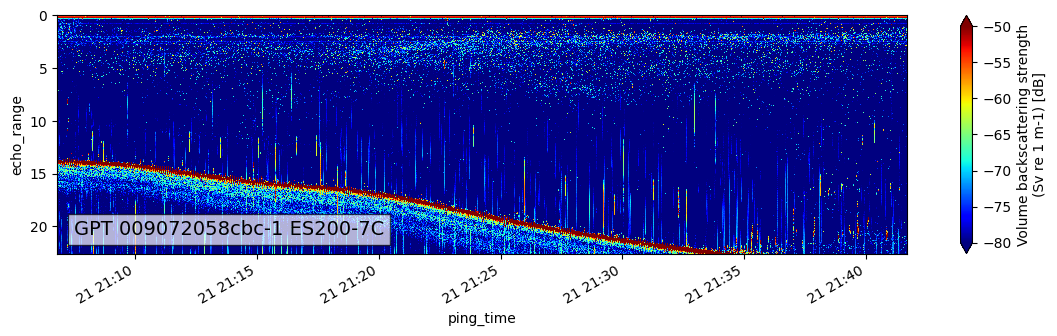

In [18]:
epviz.create_echogram(sv,vmin=-80,vmax=-50)

### Sv dataset extension

In [19]:
%%time

extended_sv = sv_dataset_extension.enrich_sv_dataset(
    sv = sv,
    echodata = ds, 
    waveform_mode="CW",
    encode_mode="power"
)
extended_sv

CPU times: user 9.72 s, sys: 5.63 s, total: 15.3 s
Wall time: 16.1 s


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 8954,
                                    range_sample: 3890, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-08-21T21:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 3887 3888 3889
  * filenames                      (filenames) int64 0
Data variables: (12/29)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    water_level                    float64 ...
    depth                          (channel, ping_time, range_sample) float64 ...
    latitude                       (ping_time) float64 nan nan 30.06 ... nan nan
    longitude                      (ping_time) float64 nan nan ... nan nan
    angle_alongship                (channel, ping_time, range_sample) float64 ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2337+g364c06a
    processing_time:              2023-11-16T09:49:07Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

In [20]:
%memit extended_sv = sv_dataset_extension.enrich_sv_dataset(sv=sv, echodata=ds, waveform_mode="CW", encode_mode="power")

peak memory: 8732.74 MiB, increment: 2668.23 MiB


### Clearing Memory

In [21]:
del ds
del sv
gc.collect()  # Run the garbage collector to free up memory immediately

780

### Noise masks

**`Transient` noise mask**

In [22]:
# %%time

# # # oceanstream_transient_fd_mask_params = {
# # #     "r0": 200,
# # #     "r1": 1000,
# # #     "n": 20,
# # #     "thr": [2, 0],
# # #     "roff": 250,
# # #     "jumps": 5,
# # #     "maxts": -35,
# # #     "start": 0,
# # #     "dask_chunking": {"ping_time": 100},
# # # }


# oceanstream_transient_fd_mask_params = {
#     "r0": 200,
#     "r1": 1000,
#     "n": 30,
#     "thr": [2, 0],
#     "roff": 250,
#     "jumps": 5,
#     "maxts": -35,
#     "start": 0,
#     "dask_chunking": {"ping_time":100, "range_sample":100}
# }

# %memit transient_mask_fd = noise_masks.create_transient_mask(extended_sv, parameters=oceanstream_transient_fd_mask_params, method="fielding")

# transient_mask_fd = add_metadata_to_mask(
#     mask=transient_mask_fd,
#     metadata={
#         "mask_type": "transient",
#         "method": "fielding",
#         "parameters": dict_to_formatted_list(oceanstream_transient_fd_mask_params),
#     },
# )

In [23]:
# transient_mask_fd = add_metadata_to_mask(
#     mask=transient_mask_fd,
#     metadata={
#         "mask_type": "transient",
#         "method": "fielding",
#         "parameters": dict_to_formatted_list(oceanstream_transient_fd_mask_params),
#     },
# )

# Sv_without_transient = attach_mask_to_dataset(extended_sv, transient_mask_fd)
# Sv_without_transient

In [24]:
# if not np.all(Sv_without_transient['mask_transient'].values):
#     print("There is at least one False in the array")
# else:
#     print("All values are True")

In [25]:
# epviz.create_echogram(Sv_without_transient,vmin=-80,vmax=-50)

In [26]:
# %%time

# oceanstream_transient_ry_mask_params = {
#     "m": 5,
#     "n": 20,
#     # "n": 5,
#     "thr": 20,
#     "excludeabove": 250,
#     "dask_chunking": {"ping_time": 100, "range_sample":100},
#     "operation": "mean",
# }


# # oceanstream_transient_ry_mask_params = {
# #     "m": 5,
# #     "n": 20,
# #     "thr": 20,
# #     "excludeabove": 250,
# #     "dask_chunking": {"ping_time":90, "range_sample":90},
# #     "operation": "mean",
# # }

# %memit transient_mask_ry = noise_masks.create_transient_mask(extended_sv, parameters=oceanstream_transient_ry_mask_params, method="ryan")

# transient_mask_ry = add_metadata_to_mask(
#     mask=transient_mask_ry,
#     metadata={
#         "mask_type": "transient",
#         "method": "ryan",
#         "parameters": dict_to_formatted_list(oceanstream_transient_ry_mask_params),
#     },
# )

**The transient noise mask:** 
- The 'ryan' method causes the kernel to crash
- For the fielding method, it took more than one hour to run, so I've turned off the process.

**`Impulse` noise mask**

In [27]:
%%time

oceanstream_impulse_mask_param = {"thr": 3, "m": 3, "n": 1}
%memit impulse_mask = noise_masks.create_impulse_mask(extended_sv, parameters=oceanstream_impulse_mask_param, method="ryan")
impulse_mask = add_metadata_to_mask(
    mask=impulse_mask,
    metadata={
        "mask_type": "impulse",
        "method": "ryan",
        "parameters": dict_to_formatted_list(oceanstream_impulse_mask_param),
    },
)

peak memory: 6406.91 MiB, increment: 1843.92 MiB
CPU times: user 10.2 s, sys: 5.74 s, total: 16 s
Wall time: 17.2 s


In [28]:
impulse_mask

<xarray.DataArray 'Sv' (channel: 4, ping_time: 8954, range_sample: 3890)>
array([[[False, False, False, ..., False, False, False],
        [False,  True,  True, ...,  True,  True, False],
        [False,  True,  True, ...,  True,  True, False],
        ...,
        [False,  True,  True, ...,  True,  True, False],
        [False,  True,  True, ...,  True,  True, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False,  True,  True, ...,  True,  True, False],
        [False,  True,  True, ...,  True,  True, False],
        ...,
        [False,  True,  True, ...,  True,  True, False],
        [False,  True,  True, ...,  True,  True, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False,  True,  True, ...,  True,  True, False],
        [False,  True,  True, ...,  True,  True, False],
        ...,
        [False,  True,  True, ...,  True,  True, False],
        [False,  True,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False,  True,  True, ...,  True,  True, False],
        [False,  True,  True, ...,  True,  True, False],
        ...,
        [False,  True,  True, ...,  True,  True, False],
        [False,  True,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * ping_time     (ping_time) datetime64[ns] 2019-08-21T21:06:46.976054784 .....
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 3885 3886 3887 3888 3889
  * channel       (channel) object 'GPT 0090720346b4-1 ES38B' ... 'GPT 009072...
Attributes:
    mask_type:   impulse
    method:      ryan
    parameters:  ['thr=3', 'm=3', 'n=1']

In [29]:
impulse_mask = add_metadata_to_mask(
    mask=impulse_mask,
    metadata={
        "mask_type": "impulse",
        "method": "ryan",
        "parameters": dict_to_formatted_list(oceanstream_impulse_mask_param),
    },
)

Sv_without_impulse = attach_mask_to_dataset(extended_sv, impulse_mask)
Sv_without_impulse 

<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 8954,
                                    range_sample: 3890, filenames: 1)
Coordinates:
  * channel                        (channel) object 'GPT 0090720346b4-1 ES38B...
  * ping_time                      (ping_time) datetime64[ns] 2019-08-21T21:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 3887 3888 3889
  * filenames                      (filenames) int64 0
Data variables: (12/30)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    depth                          (channel, ping_time, range_sample) float64 ...
    latitude                       (ping_time) float64 nan nan 30.06 ... nan nan
    longitude                      (ping_time) float64 nan nan ... nan nan
    angle_alongship                (channel, ping_time, range_sample) float64 ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
    mask_impulse                   (channel, ping_time, range_sample) bool Fa...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2337+g364c06a
    processing_time:              2023-11-16T09:49:07Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

In [30]:
%%time

process_parameters = {
    "mask_impulse": {
        "var_name": "Sv",
    },
}
%memit cleaned_ds_impulse = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(Sv_without_impulse, process_parameters)


peak memory: 6568.98 MiB, increment: 1063.03 MiB
CPU times: user 1.83 s, sys: 328 ms, total: 2.16 s
Wall time: 2.77 s


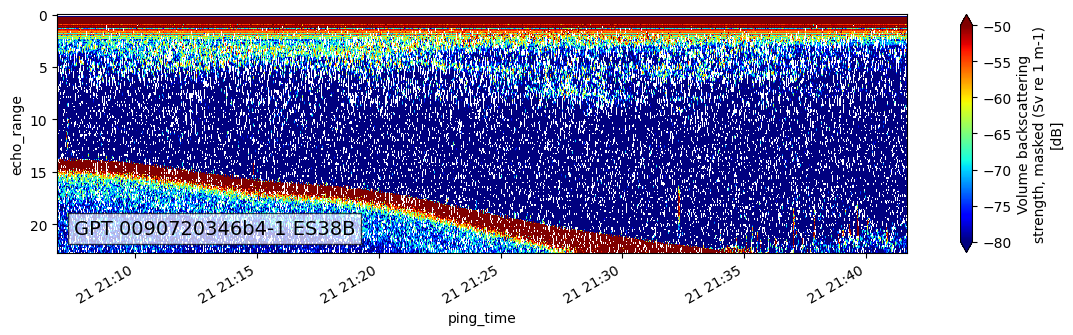

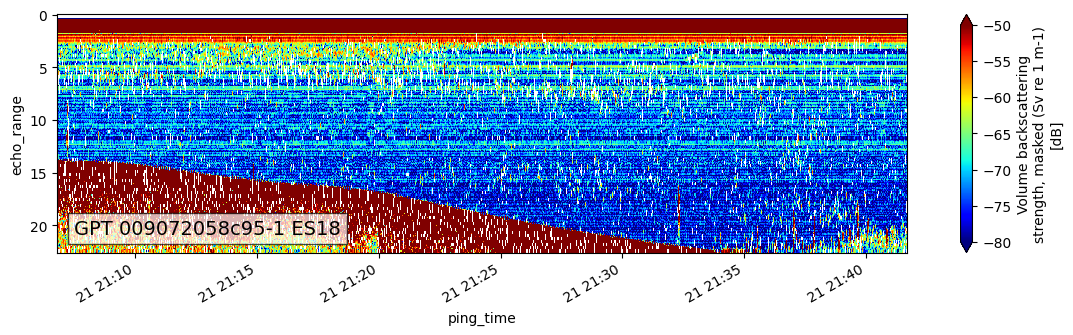

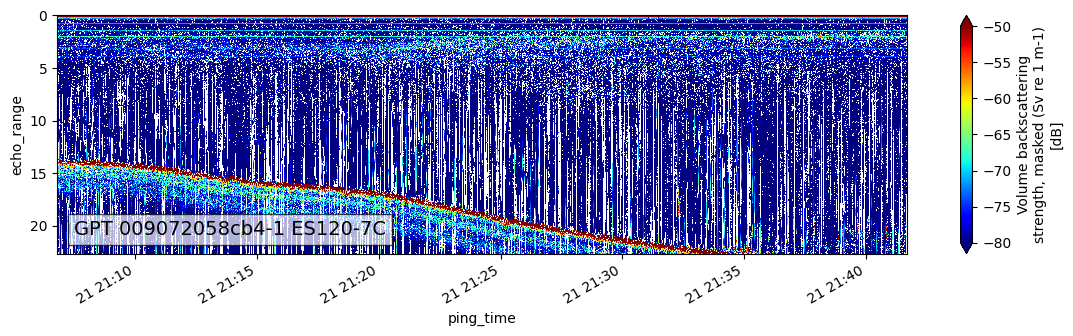

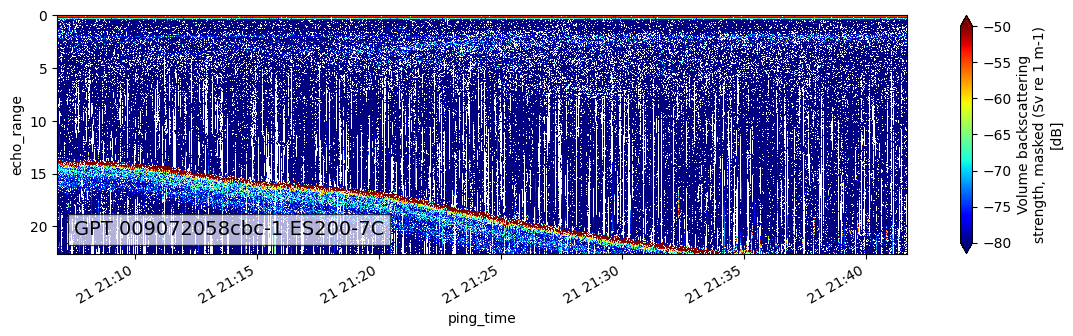

In [31]:
epviz.create_echogram(cleaned_ds_impulse,vmin=-80,vmax=-50)

**`Attenuation` mask**

In [32]:
%%time

# oceanstream_attenuation_mask_params = {
#         "r0": 180,
#         "r1": 280,
#         "n": 30,
#         "m": None,
#         "thr": -6,
#         "start": 0,
#         "offset": 0,
#     }

oceanstream_attenuation_mask_params = {
    "r0": 180,
    "r1": 280,
    "n": 5,
    "m": None,
    "thr": -5,
    "start": 0,
    "offset": 0,
}

%memit attenuation_mask = noise_masks.create_attenuation_mask(cleaned_ds_impulse, parameters=oceanstream_attenuation_mask_params, method="ryan")
attenuation_mask = add_metadata_to_mask(
    mask=attenuation_mask,
    metadata={
        "mask_type": "attenuation",
        "method": "ryan",
        "parameters": dict_to_formatted_list(oceanstream_attenuation_mask_params),
    },
)

peak memory: 9192.66 MiB, increment: 5012.44 MiB
CPU times: user 32.4 s, sys: 29.6 s, total: 1min 2s
Wall time: 1min 8s


In [33]:
attenuation_mask

<xarray.DataArray (channel: 4, ping_time: 8954, range_sample: 3890)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [ True,  True,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * ping_time     (ping_time) datetime64[ns] 2019-08-21T21:06:46.976054784 .....
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 3885 3886 3887 3888 3889
  * channel       (channel) object 'GPT 0090720346b4-1 ES38B' ... 'GPT 009072...
Attributes:
    mask_type:   attenuation
    method:      ryan
    parameters:  ['r0=180', 'r1=280', 'n=5', 'm=None', 'thr=-5', 'start=0', '...

In [34]:
Sv_without_att = attach_mask_to_dataset(extended_sv, attenuation_mask)
Sv_without_att

<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 8954,
                                    range_sample: 3890, filenames: 1)
Coordinates:
  * channel                        (channel) object 'GPT 0090720346b4-1 ES38B...
  * ping_time                      (ping_time) datetime64[ns] 2019-08-21T21:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 3887 3888 3889
  * filenames                      (filenames) int64 0
Data variables: (12/30)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    depth                          (channel, ping_time, range_sample) float64 ...
    latitude                       (ping_time) float64 nan nan 30.06 ... nan nan
    longitude                      (ping_time) float64 nan nan ... nan nan
    angle_alongship                (channel, ping_time, range_sample) float64 ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
    mask_attenuation               (channel, ping_time, range_sample) bool Fa...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2337+g364c06a
    processing_time:              2023-11-16T09:49:07Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

In [35]:
%%time

process_parameters = {
    "mask_attenuation": {
        "var_name": "Sv",
    },
}
%memit cleaned_ds_att = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(Sv_without_att, process_parameters)

peak memory: 2397.70 MiB, increment: 1777.04 MiB
CPU times: user 2.3 s, sys: 1.66 s, total: 3.95 s
Wall time: 7.8 s


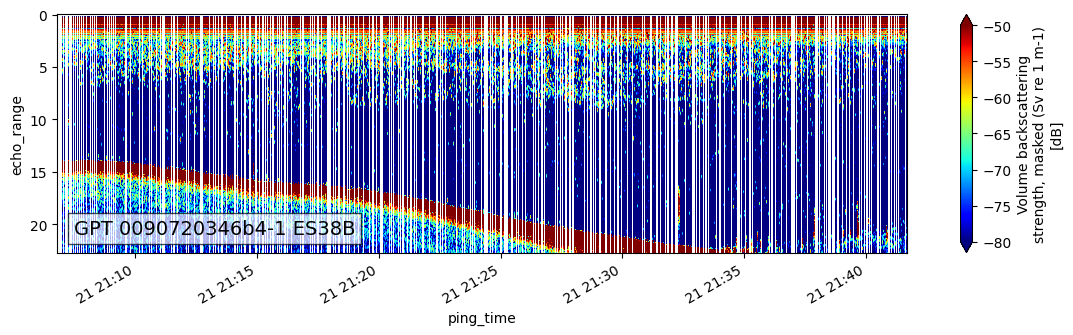

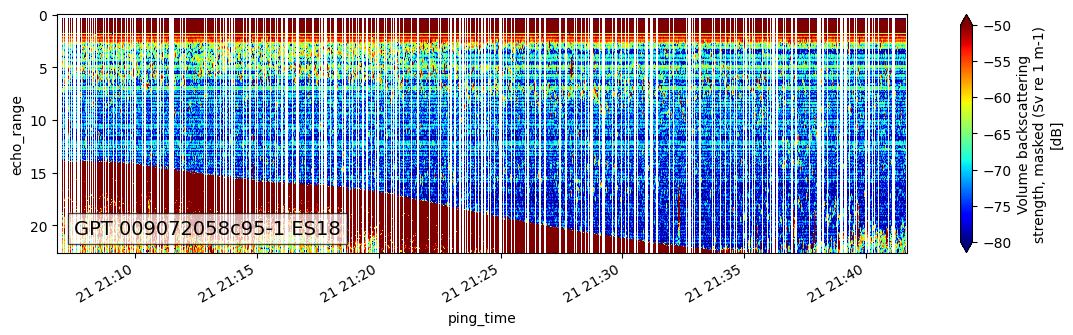

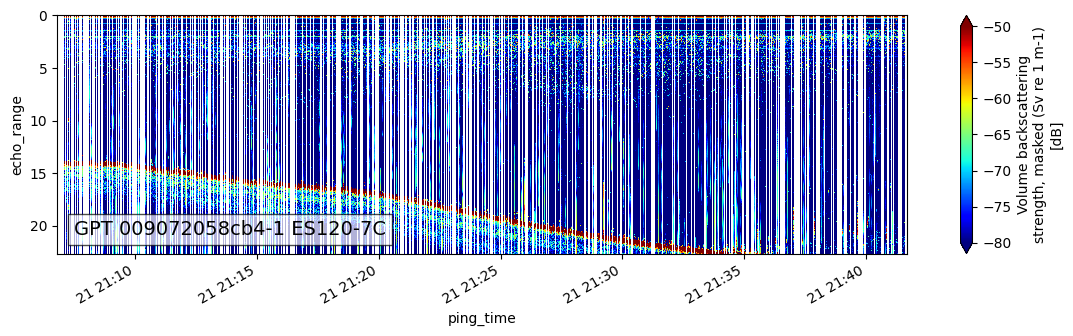

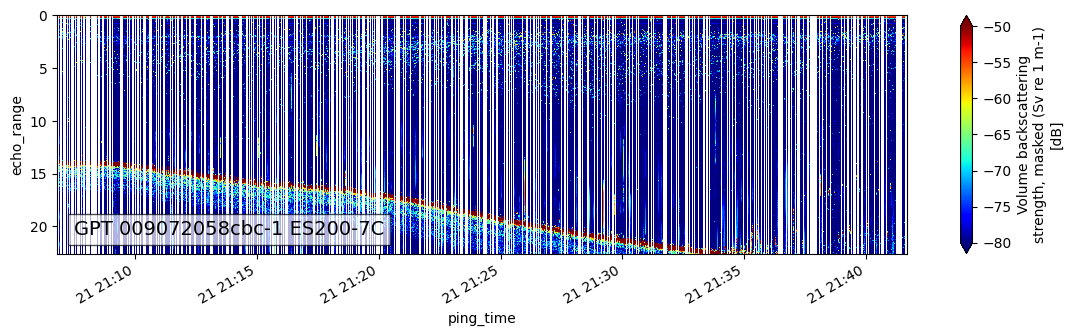

In [36]:
epviz.create_echogram(cleaned_ds_att,vmin=-80,vmax=-50)

### `Seabed` masks

In [37]:
%%time

# `blackwell_mod`

BLACKWELL_MOD_DEFAULT_PARAMS = {
    "theta": None,
    "phi": None,
    "r0": 10,
    "r1": 1000,
    "tSv": -75,
    "ttheta": 702,
    "tphi": 282,
    "wtheta": 28,
    "wphi": 52,
    "rlog": None,
    "tpi": None,
    "freq": None,
    "rank": 50,
}
%memit blackwell_mod_mask = noise_masks.create_seabed_mask(extended_sv, method="blackwell_mod", parameters = BLACKWELL_MOD_DEFAULT_PARAMS,)
blackwell_mod_mask = add_metadata_to_mask(
    mask=blackwell_mod_mask , 
    metadata={
        "mask_type": "false_seabed", 
        "method":"blackwell_mod",
        "parameters": dict_to_formatted_list(BLACKWELL_MOD_DEFAULT_PARAMS),
    }
)

Sv_false_seabed = attach_mask_to_dataset(
    extended_sv, 
    blackwell_mod_mask
)

/Users/simedroniraluca/Documents/pineview/oceanstream/.venv/lib/python3.9/site-packages/echopype/mask/seabed.py:496: UserWarning: Aliased seabed not detected in Theta & Phi.A default mask with all True values is returned.
  warnings.warn(


peak memory: 8939.96 MiB, increment: 2599.60 MiB
CPU times: user 1min 7s, sys: 5.6 s, total: 1min 13s
Wall time: 1min 17s


In [38]:
%%time

process_parameters = {
    "mask_false_seabed": {
        "var_name": "Sv",
    },
}
%memit cleaned_ds_fseabed = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(Sv_false_seabed, process_parameters)

peak memory: 8772.61 MiB, increment: 265.91 MiB
CPU times: user 1.35 s, sys: 852 ms, total: 2.2 s
Wall time: 3.59 s


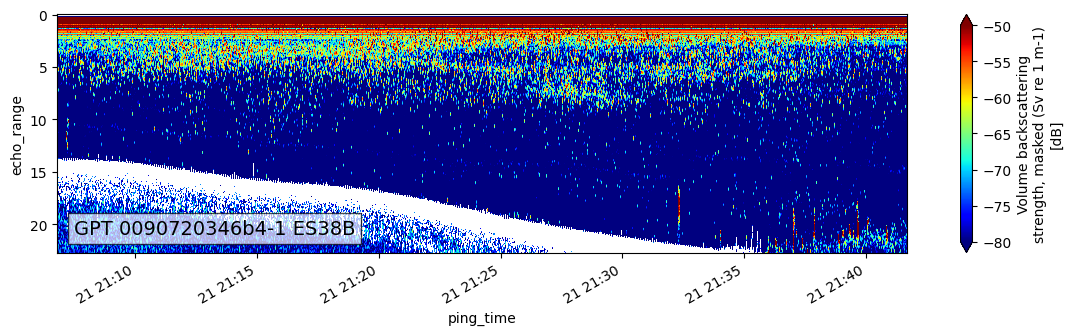

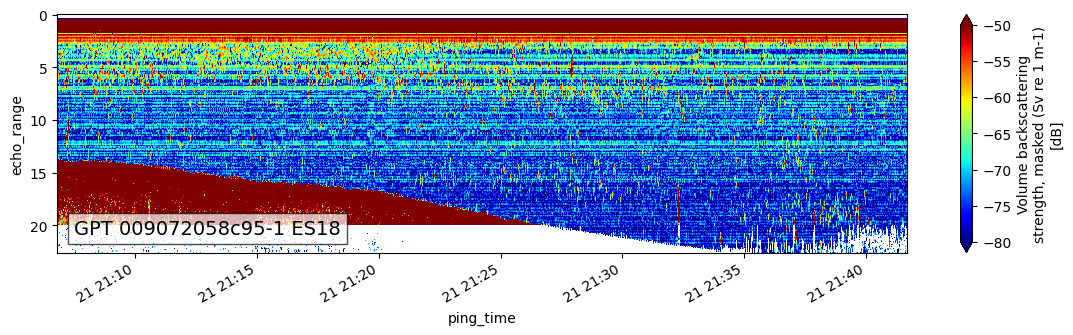

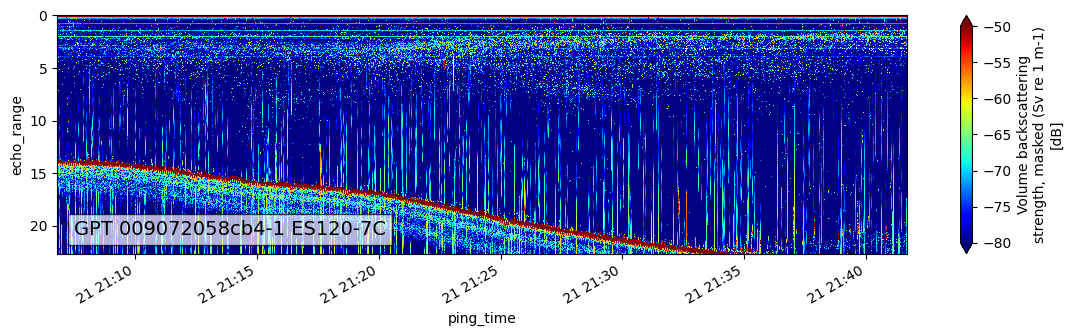

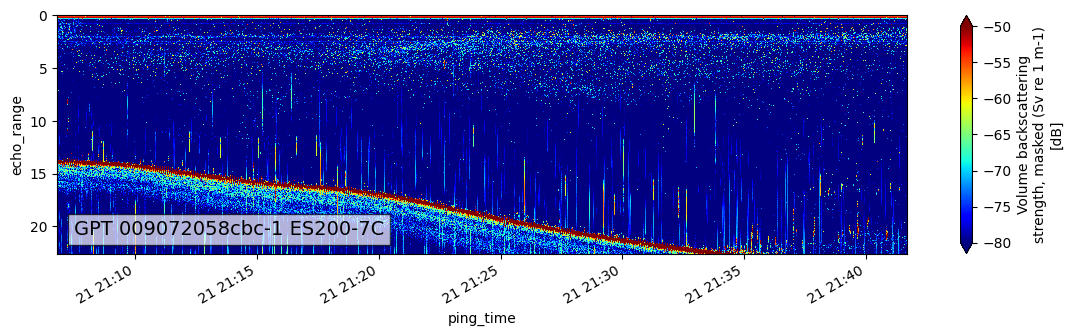

In [39]:
epviz.create_echogram(cleaned_ds_fseabed,vmin=-80,vmax=-50)

In [40]:
# `ariza`

ARIZA_PARAMS = {
    "r0": 10,
    "r1": 1000,
    "roff": 0,
    "thr": -35,
    "ec": 15,
    "ek": (1, 3),
    "dc": 150,
    "dk": (1, 3),
}

%memit ariza_mask = noise_masks.create_seabed_mask(extended_sv, method="ariza", parameters=ARIZA_PARAMS)

ariza_mask = add_metadata_to_mask(
    mask=ariza_mask,
    metadata={
        "mask_type": "seabed",
        "method": "ariza",
        "parameters": dict_to_formatted_list(ARIZA_PARAMS),
    },
)
Sv_seabed = attach_mask_to_dataset(
    extended_sv, 
    ariza_mask
)

peak memory: 6210.95 MiB, increment: 688.17 MiB


In [41]:
%%time

process_parameters = {
    "mask_seabed": {
        "var_name": "Sv",
    },
}
%memit cleaned_ds_seabed = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(Sv_seabed, process_parameters)

peak memory: 4047.84 MiB, increment: 490.99 MiB
CPU times: user 2.17 s, sys: 702 ms, total: 2.87 s
Wall time: 4.15 s


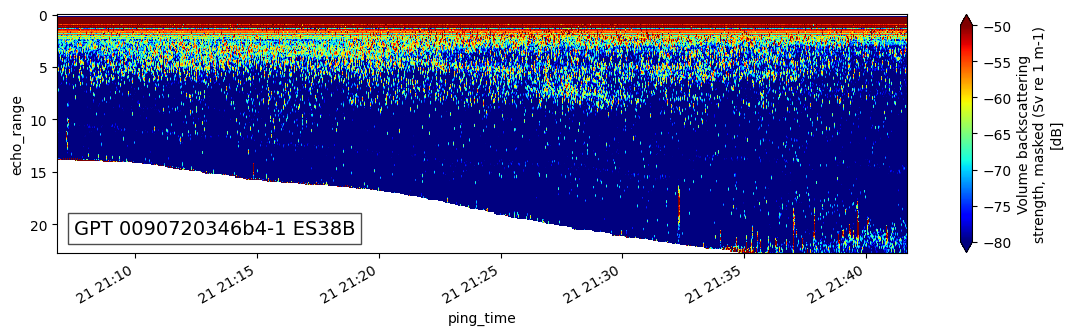

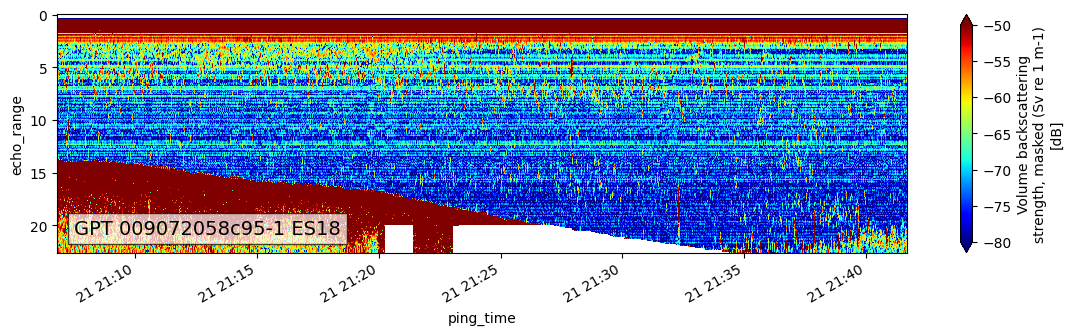

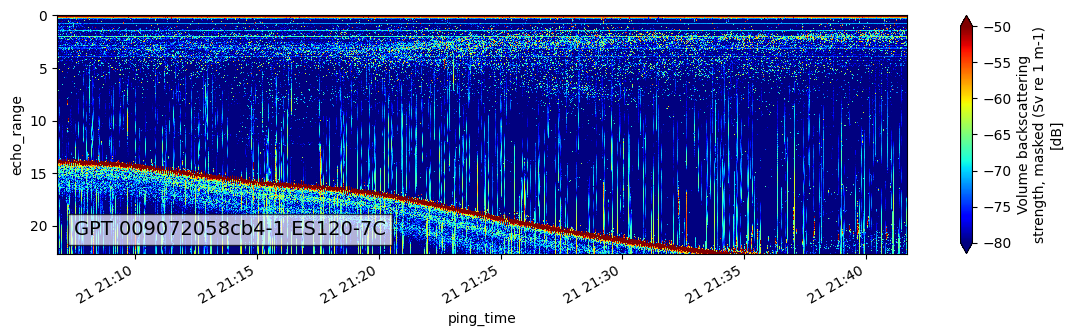

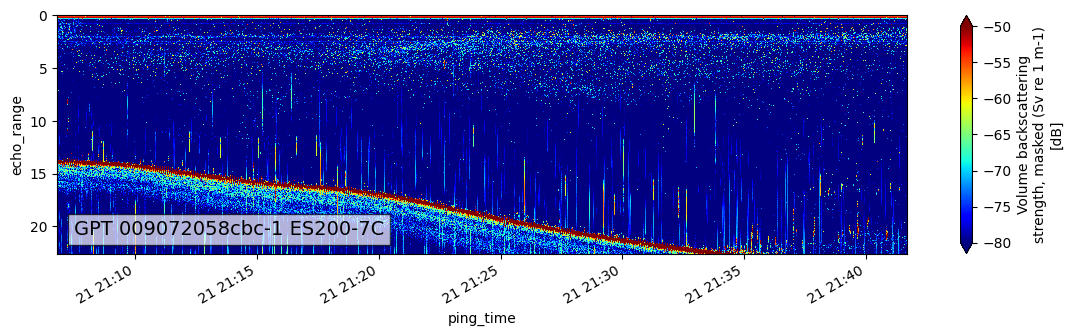

In [42]:
epviz.create_echogram(cleaned_ds_seabed,vmin=-80,vmax=-50)

In [43]:
%%time

# `blackwell`

BLACKWELL_DEFAULT_PARAMS = {
    "theta": None,
    "phi": None,
    "r0": 10,
    "r1": 1000,
    "tSv": -75,
    "ttheta": 702,
    "tphi": 282,
    "wtheta": 28,
    "wphi": 52,
}
%memit blackwell_mask = noise_masks.create_seabed_mask(extended_sv, method="blackwell", parameters = BLACKWELL_DEFAULT_PARAMS,)
blackwell_mask = add_metadata_to_mask(
    mask=blackwell_mask , 
    metadata={
        "mask_type": "false_seabed", 
        "method":"blackwell",
        "parameters": dict_to_formatted_list(BLACKWELL_DEFAULT_PARAMS),
    }
)

Sv_false_bw_seabed = attach_mask_to_dataset(
    extended_sv, 
    blackwell_mask
)

/Users/simedroniraluca/Documents/pineview/oceanstream/.venv/lib/python3.9/site-packages/echopype/mask/seabed.py:336: UserWarning: No aliased seabed detected in Theta & Phi. A default mask with all True values is returned.
  warnings.warn(


peak memory: 3035.52 MiB, increment: 536.45 MiB
CPU times: user 1min 13s, sys: 6.24 s, total: 1min 19s
Wall time: 1min 23s


In [44]:
Sv_false_bw_seabed

<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 8954,
                                    range_sample: 3890, filenames: 1)
Coordinates:
  * channel                        (channel) object 'GPT 0090720346b4-1 ES38B...
  * ping_time                      (ping_time) datetime64[ns] 2019-08-21T21:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 3887 3888 3889
  * filenames                      (filenames) int64 0
Data variables: (12/30)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    depth                          (channel, ping_time, range_sample) float64 ...
    latitude                       (ping_time) float64 nan nan 30.06 ... nan nan
    longitude                      (ping_time) float64 nan nan ... nan nan
    angle_alongship                (channel, ping_time, range_sample) float64 ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
    mask_false_seabed              (channel, ping_time, range_sample) bool Tr...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2337+g364c06a
    processing_time:              2023-11-16T09:49:07Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

In [45]:
%%time

process_parameters = {
    "mask_false_seabed": {
        "var_name": "Sv",
    },
}
%memit cleaned_ds_f_bw_seabed = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(Sv_false_bw_seabed, process_parameters)

peak memory: 3136.30 MiB, increment: 947.76 MiB
CPU times: user 1.73 s, sys: 2.58 s, total: 4.31 s
Wall time: 6.34 s


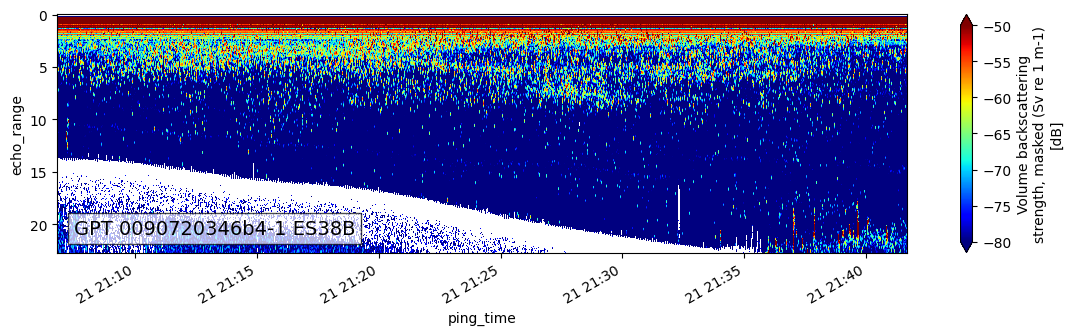

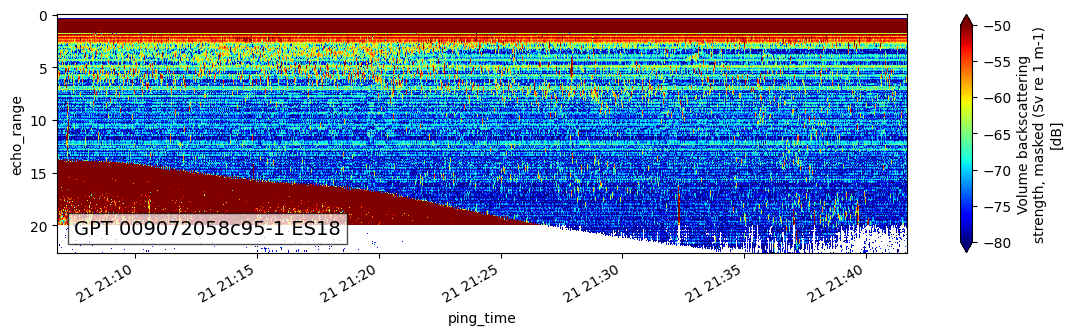

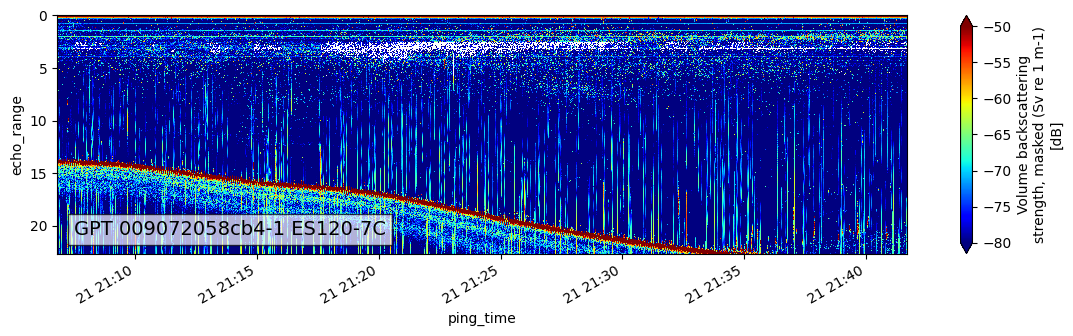

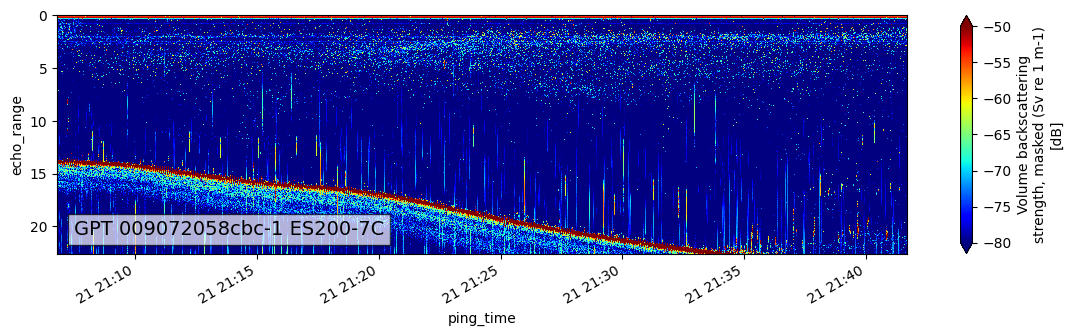

In [46]:
epviz.create_echogram(cleaned_ds_f_bw_seabed,vmin=-80,vmax=-50)

### Shoal mask

In [47]:
# %%time

# %%memit ds_Sv_with_shoal_mask = shoal_detection_handler.attach_shoal_mask_to_ds(extended_sv)
# ds_Sv_with_shoal_mask

In [48]:
# %%time

# process_parameters = {
#     'mask_shoal': {
#         'var_name': 'Sv',
#     }
# }

# %%memit organisms_ds = apply_mask_organisms_in_order(ds_Sv_with_shoal_mask, process_parameters)


In [49]:
# epviz.create_echogram(organisms_ds,vmin=-80,vmax=-50)

**The shoal detection process is notably time-consuming; on my machine, the computation of the shoal mask took more than 7 hours, prompting me to halt the process due to the excessive duration.**